## Predicting Bike Rentals

Hadi Fanaee-T at the University of Porto compiled this data into a CSV file, which you'll be working with in this project. The file contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day. You can download the data from the University of California, Irvine's website. If you need help at any point, you can consult the solution notebook in our GitHub repository.

Here are the descriptions for the relevant columns:

instant - A unique sequential ID number for each row
dteday - The date of the rentals
season - The season in which the rentals occurred
yr - The year the rentals occurred
mnth - The month the rentals occurred
hr - The hour the rentals occurred
holiday - Whether or not the day was a holiday
weekday - The day of the week (as a number, 0 to 7)
workingday - Whether or not the day was a working day
weathersit - The weather (as a categorical variable)
temp - The temperature, on a 0-1 scale
atemp - The adjusted temperature
hum - The humidity, on a 0-1 scale
windspeed - The wind speed, on a 0-1 scale
casual - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
registered - The number of registered riders (people who had already signed up)
cnt - The total number of bike rentals (casual + registered)

In this project, you'll try to predict the total number of bikes people rented in a given hour. You'll predict the cnt column using all of the other columns, except for casual and registered. To accomplish this, you'll create a few different machine learning models and evaluate their performance.

#### Introduction to the dataset / first exploration

quick overview to see what col need fixing

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [15]:
bike_rentals = pd.read_csv('bike_rental_hour.csv')
bike_rentals['dteday']=pd.to_datetime(bike_rentals['dteday'])

In [16]:
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [17]:
bike_rentals.dtypes

instant                int64
dteday        datetime64[ns]
season                 int64
yr                     int64
mnth                   int64
hr                     int64
holiday                int64
weekday                int64
workingday             int64
weathersit             int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
cnt                    int64
dtype: object

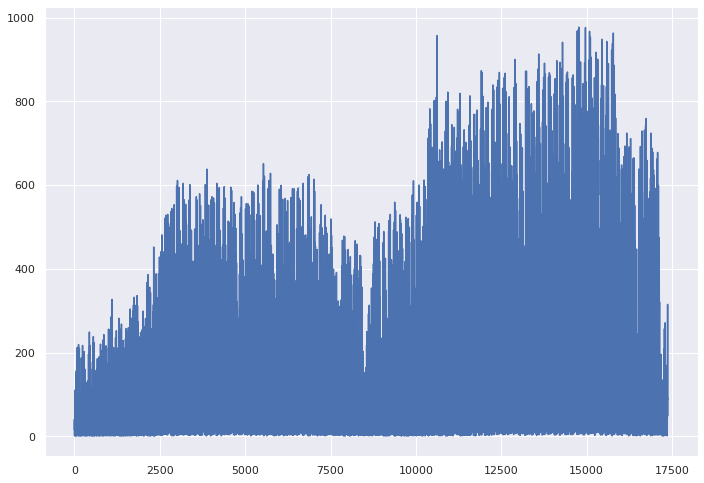

In [30]:
bike_rentals['cnt'].plot()

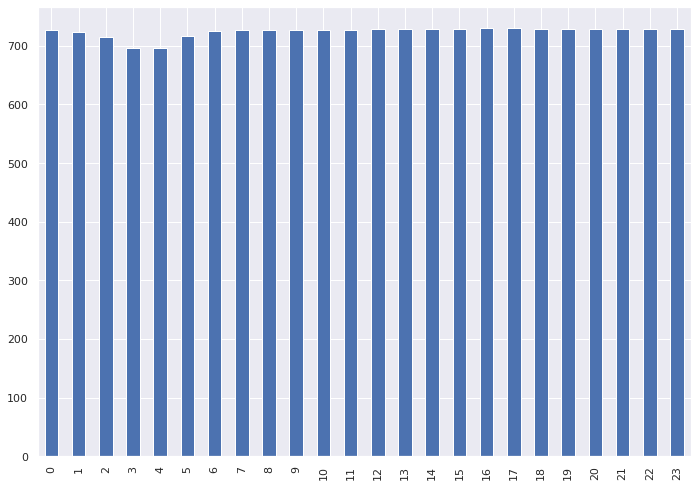

In [44]:
bike_rentals['hr'].value_counts().sort_index().plot.bar()

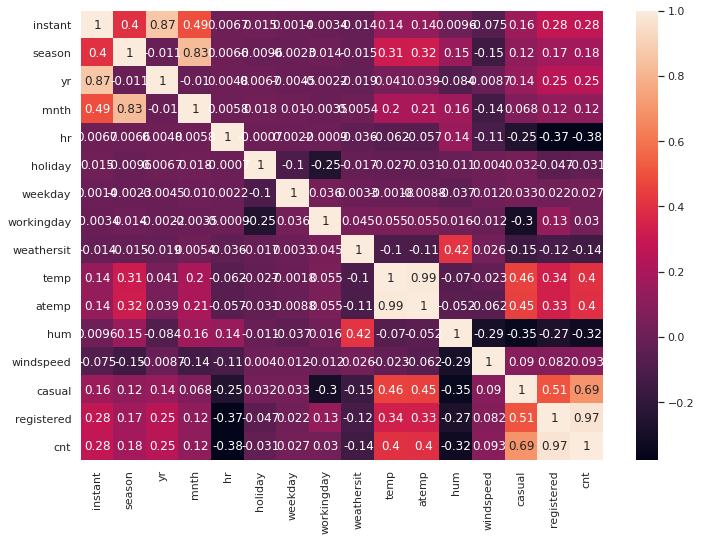

In [61]:
correlations=bike_rentals.corr()
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(correlations,annot=True)

Cnt columns is higly correlated with registered and casual columns.

## New features

we gonna transform some of this features in more meaningful ones, for instance in the hr col, ML  would treat each hours differentally without understand that some are links (such as morning, afternoon, nights....)

In [48]:
#transforting hrs feature
def assign_label(hour):
  if hour >= 6 and hour <12:
    return 1
  elif hour >=12 and hour < 18:
    return 2
  elif hour >=18 and hour <24:
    return 3
  elif hour >=0 and hour < 6:
    return 4

In [49]:
bike_rentals['hr']=bike_rentals['hr'].apply(assign_label)

## split train / test

we gonna use the pandas sample method for train and for test we gonna select only the rows which are not in train

the use of **~** means inverse 

In [52]:
train=bike_rentals.sample(frac=0.8)

In [55]:
#creating a boolean mask for test
test_mask=bike_rentals.index.isin(train.index)

In [59]:
test=bike_rentals[~test_mask]

### modelling col with corr > 0.25
i decided to use all the features with a corr > 0.25 with cnt

```
`# This is formatted as code`
```



In [103]:
#creation of a mask
mask_selection_features=bike_rentals.corr()['cnt'].abs() > 0.25

In [104]:
#apllying the mask to keep only the columns with high correlation
features=bike_rentals.corr()['cnt'][mask_selection_features].index

In [105]:
bike_rentals[features].corr()['cnt'].abs()

instant       0.278379
yr            0.250495
hr            0.378318
temp          0.404772
atemp         0.400929
hum           0.322911
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

In [106]:
#we drop cols:cnt, casual, dteday, and registered

In [107]:
features=features.drop(['cnt', 'casual', 'registered'])

In [108]:
features

Index(['instant', 'yr', 'hr', 'temp', 'atemp', 'hum'], dtype='object')

In [109]:
### LinearRegression

In [116]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import  mean_absolute_error 
lr=LinearRegression()
lr.fit(train[features],train['cnt'])
predictions_lr=lr.predict(test[features])

105.16211298742542


Text(0.5, 1.0, 'real vs predictions, lr high corr features')

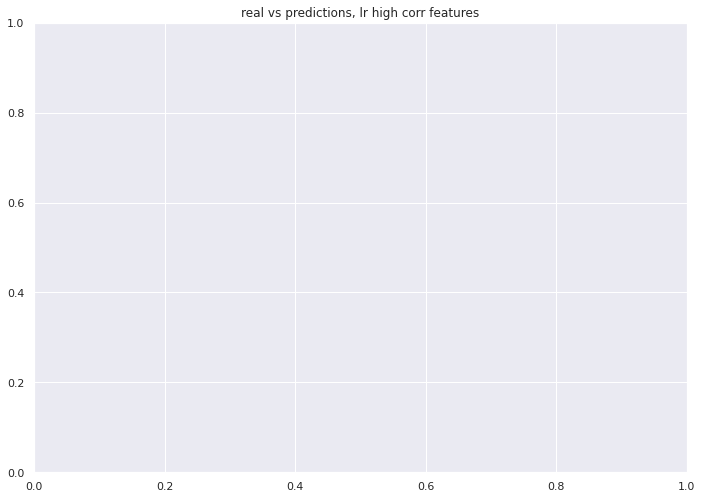

In [136]:
#MAE
mae_lr=mean_absolute_error(test['cnt'],predictions_lr)
print(mae_lr)
plt.title('real vs predictions, lr high corr features')


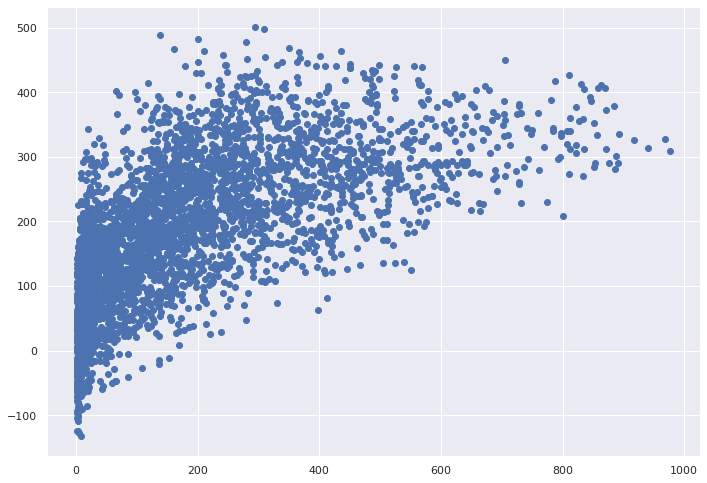

In [112]:
plt.scatter(test['cnt'],lr_predictions)

Conclusion LR: the lr model has return a mae of 105 when using the columns with a corr > 0.25 with Cnt

### LR model with all cols (for try)

In [121]:
#features
all_features=bike_rentals.columns.drop(['cnt', 'casual', 'registered','dteday'])
all_features

Index(['instant', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed'],
      dtype='object')

105.13226034625829


Text(0.5, 1.0, 'real vs predictions, lr with all features')

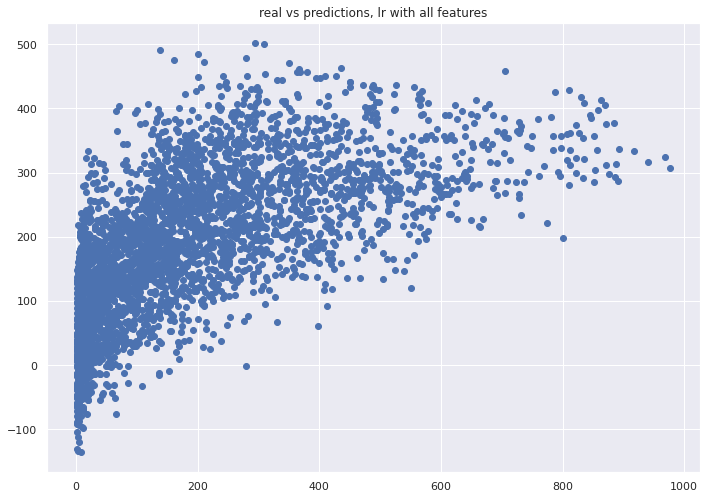

In [135]:
lr2=LinearRegression()
lr2.fit(train[all_features],train['cnt'])
predictions_lr2=lr2.predict(test[all_features])
mae_lr2=mean_absolute_error(test['cnt'],predictions_lr2)

print(mae_lr2)
plt.scatter(test['cnt'],predictions_lr2)
plt.title('real vs predictions, lr with all features')


we see that include all features do not increase the predicions and make it even a bit less good. 
maybe a subset of features of the col with high corr might better strategy or to do some features ingineering with the weather :) 

#### modelling with Decision Tree
same with try with high corr col and all col then we play with the min_sample_leaf parameter

In [127]:
from sklearn.tree import DecisionTreeRegressor

90.98360184119677


Text(0.5, 1.0, 'real vs predictions, dtr high corr features')

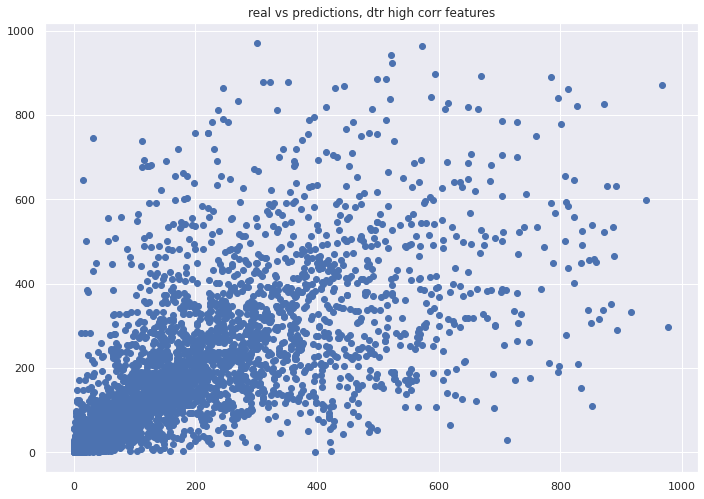

In [137]:
dtr=DecisionTreeRegressor()
dtr.fit(train[features],train['cnt'])
predictions_dtr=dtr.predict(test[features])

mae_dtr=mean_absolute_error(test['cnt'],predictions_dtr
                            )
print(mae_dtr)
plt.scatter(test['cnt'],predictions_dtr)
plt.title('real vs predictions, dtr high corr features')


87.70310701956272


Text(0.5, 1.0, 'real vs predictions, dtr with all features')

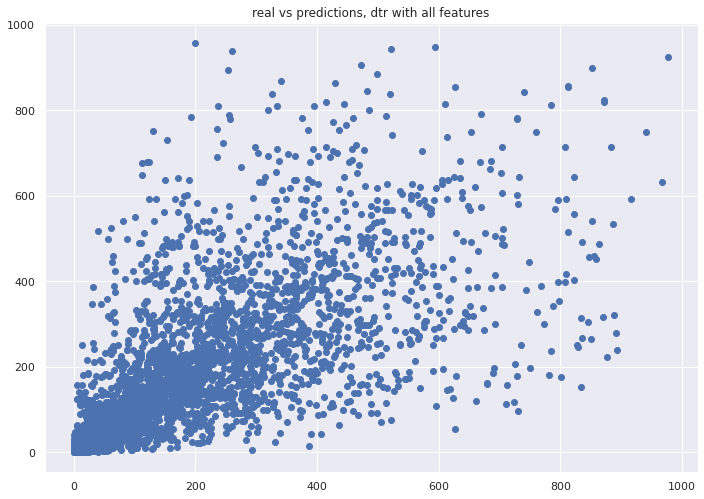

In [134]:
dtr2=DecisionTreeRegressor()
dtr2.fit(train[all_features],train['cnt'])
predictions_dtr2=dtr2.predict(test[all_features])

mae_dtr2=mean_absolute_error(test['cnt'],predictions_dtr2
                            )
print(mae_dtr2)
plt.scatter(test['cnt'x],predictions_dtr2)
plt.title('real vs predictions, dtr with all features')

index min mae dtr3 14
78.82858428222056


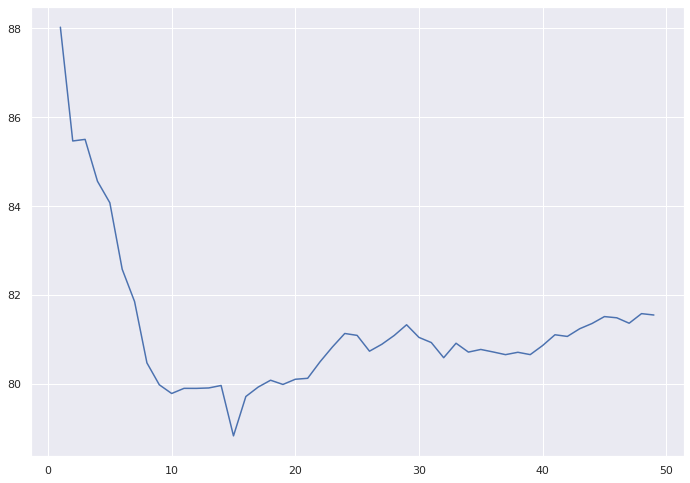

In [164]:
#setting min sample leaf parameters
maes_dtr3=list()
for n in range(1,50):
  dtr3=DecisionTreeRegressor(min_samples_leaf=n)
  dtr3.fit(train[all_features],train['cnt'])

  predictions_dtr3=dtr3.predict(test[all_features])
  mae_dtr3=mean_absolute_error(test['cnt'],predictions_dtr3
                              )
  #print(n,':',mae_dtr3)
  maes_dtr3.append(mae_dtr3)
  #plt.scatter(test['cnt'],predictions_dtr3)
  #plt.title('real vs predictions, dtr with all features and min_sample_left set')

print('index min mae dtr3',maes_dtr3.index(min(maes_dtr3)))
print(min(maes_dtr3))

plt.plot(range(1,50),maes_dtr3)


index min mae dtr4 30
84.38253179332925


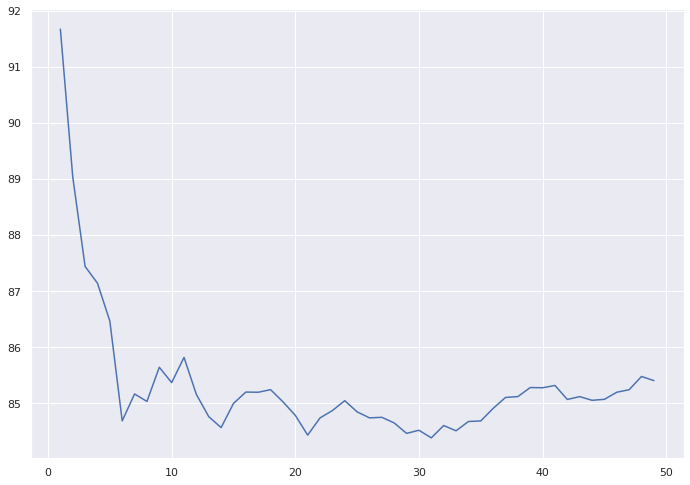

In [166]:
#high corr features and min samples leaf:
#setting min sample leaf parameters
maes_dtr4=list()
for n in range(1,50):
  dtr4=DecisionTreeRegressor(min_samples_leaf=n)
  dtr4.fit(train[features],train['cnt'])

  predictions_dtr4=dtr4.predict(test[features])
  mae_dtr4=mean_absolute_error(test['cnt'],predictions_dtr4
                              )
  #print(n,':',mae_dtr4)
  maes_dtr4.append(mae_dtr4)
  #plt.scatter(test['cnt'],predictions_dtr3)
  #plt.title('real vs predictions, dtr with all features and min_sample_left set')

print('index min mae dtr4',maes_dtr4.index(min(maes_dtr4)))
print(min(maes_dtr4))

plt.plot(range(1,50),maes_dtr4)

###conclusion dtr
From a MAE of 90 bikes we went down to 78 with all columns and setting min_samples_leaf to 15 (index=14 but starts at 0 => 15 bikes)

#### Modelling with RF 
same strategy than DTR

In [169]:
from sklearn.ensemble import RandomForestRegressor

In [173]:
#high corr features
rf=RandomForestRegressor()

rf.fit(train[features],train['cnt'])

predictions_rf=rf.predict(test[features])
mae_rf=mean_absolute_error(test['cnt'],predictions_rf)
print(mae_rf)

74.27031357882625


So the baseline of RF is already better of what we obtained with decision tree and tweaking some parameters

In [172]:
#now same model all features
rf2=RandomForestRegressor()

rf2.fit(train[all_features],train['cnt'])

predictions_rf2=rf2.predict(test[all_features])
mae_rf2=mean_absolute_error(test['cnt'],predictions_rf2)
print(mae_rf2)

70.31990506329113


index min mae rf3 1
69.85600690448791


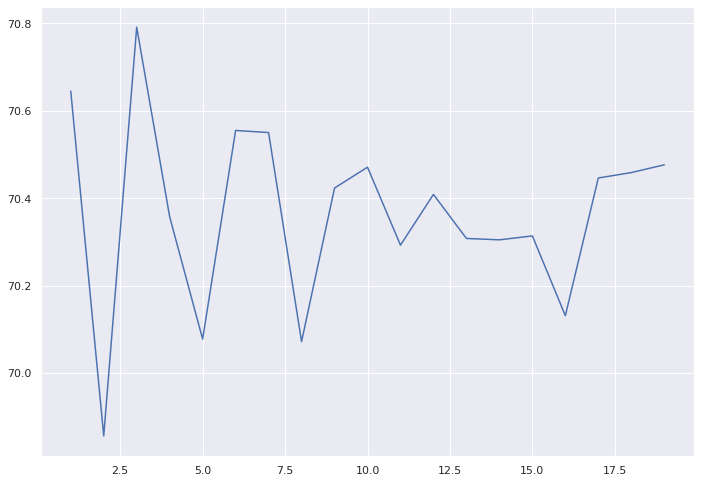

In [185]:
#playing with n and all features

maes_rf3=list()
for n in range(1,20):
  rf3=RandomForestRegressor()

  rf3.fit(train[all_features],train['cnt'])

  predictions_rf3=rf3.predict(test[all_features])
  mae_rf3=mean_absolute_error(test['cnt'],predictions_rf3)

  maes_rf3.append(mae_rf3)

print('index min mae rf3',maes_rf3.index(min(maes_rf3)))
print(min(maes_rf3))

plt.plot(range(1,20),maes_rf3)


index min mae rf3 2
73.91868814729574


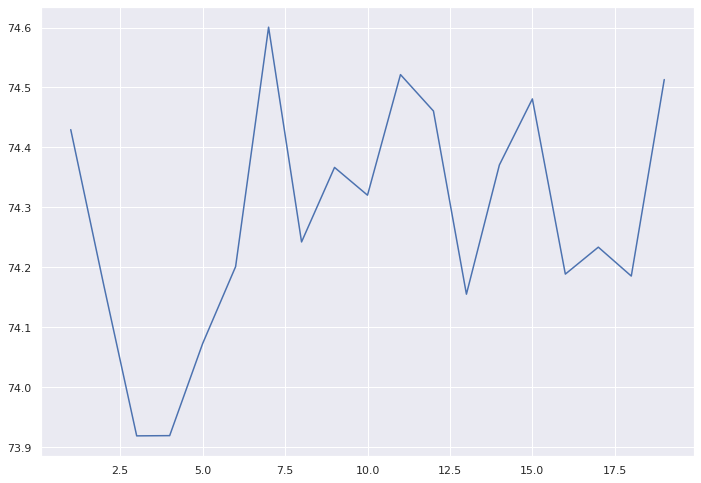

In [186]:
#playing with n and high corr features
maes_rf4=list()
for n in range(1,20):
  rf4=RandomForestRegressor()

  rf4.fit(train[features],train['cnt'])

  predictions_rf4=rf4.predict(test[features])
  mae_rf4=mean_absolute_error(test['cnt'],predictions_rf4)

  maes_rf4.append(mae_rf4)

print('index min mae rf3',maes_rf4.index(min(maes_rf4)))
print(min(maes_rf4))

plt.plot(range(1,20),maes_rf4)

Conclusions RF modelling: 
it takes a long time to play around with RF vs LR or DTR bu base results are already better.

For all features, the best mae is 69.85 bikes with a min_samples_leaf of 2.
For high corr features the best mae is 73.9 with a min_samples_leaf of 3

## To go further
- Calculate additional features, such as:
  - An index combining temperature, humidity, and wind speed
- Try predicting casual and registered instead of cnt.